<img src="IMG/bandeaux/Diapositive8.PNG" align=center>

# CMEMS_3 DIVE 
# Part 4: assimilating altimetry in a 3D model

Observing System Experiments (OSE) were carried out to estimate the benefit of a satellite constellation with several altimeters by using data assimilation in an ocean 1/12° Atlantic model.

In 2012, the altimeters Jason2, Jason1 geodetic orbit and CryoSat2 were flying (and Envisat at the beginning of the year).

Data from those altimeters were assimilated, adding one altimeter at a time, in the 1/12° Atlantic+Med Mercator Ocean analysis system (PSY2).

Thanks to these OSE experiments we will look at the impact of adding altimeters on different physical model variables.

***
**General Note 1**: Execute each cell through the <button class="btn btn-default btn-xs"><i class="icon-play fa fa-play"></i></button> button from the top MENU (or keyboard shortcut `Shift` + `Enter`).<br>
<br>
**General Note 2**: If, for any reason, the kernel is not working anymore, in the top MENU, click on the <button class="btn btn-default btn-xs"><i class="fa fa-repeat icon-repeat"></i></button> button. Then, in the top MENU, click on "Cell" and select "Run All Above Selected Cell".<br>
***

First, the notebook must be set up with all the necessary tools available from the Jupyter Notebook Ecosystem.

| Module name | Description |
| :---: | :---|
| **numpy** | [NumPy](https://numpy.org/) allows carrying out scientific computing with Python and managing ND-arrays |
| **xarray** | [Xarray](http://xarray.pydata.org/en/stable/) handles netCDF files in an intuitive and interactive way. |
| **netCDF4** | [netCDF4](https://unidata.github.io/netcdf4-python/) handles netCDF4 and netCDF3 files. |
| **matplotlib** |[Matplotlib](https://matplotlib.org/) is a Python numerical plotting library |
| **cartopy** |[Cartopy](https://scitools.org.uk/cartopy/docs/latest/) is a library for plotting 2D data on maps. |

In [5]:
import os
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
from scipy.interpolate import griddata

In [6]:
# define the paths of the netcdf files to use
    ## model data
path_file1 = 'DIVE/OSE/DATA/Data6/RUN_0ALTI/PSY2V4R4_1dAV_20121104_20121105_grid2D_R20121107_1outof4.nc'
path_file2 = 'DIVE/OSE/DATA/Data6/RUN_1ALTI/PSY2V4R4_1dAV_20121104_20121105_grid2D_R20121107_1outof4.nc'
path_file3 = 'DIVE/OSE/DATA/Data6/RUN_2ALTI/PSY2V4R4_1dAV_20121104_20121105_grid2D_R20121107_1outof4.nc'
path_file4 = 'DIVE/OSE/DATA/Data6/RUN_3ALTI/PSY2V4R4_1dAV_20121104_20121105_grid2D_R20121107_1outof4.nc'
path_file5 = 'DIVE/OSE/DATA/Data6/HYBRID_MSSH_NATL12_v2.0_1outof4.nc'

    ## altimetry observations
path_file6 = 'DIVE/OSE/DATA/Data6/ALTI_FILES/dt_global_j2_sla_vfec_20121104_20140106.nc'
path_file7 = 'DIVE/OSE/DATA/Data6/ALTI_FILES/dt_global_j1g_sla_vfec_20121104_20140106.nc'
path_file8 = 'DIVE/OSE/DATA/Data6/ALTI_FILES/dt_global_c2_sla_vfec_20121104_20140106.nc'


# open the netcdf files
file1 = xr.open_dataset(path_file1)
file2 = xr.open_dataset(path_file2)
file3 = xr.open_dataset(path_file3)
file4 = xr.open_dataset(path_file4)
file5 = nc.Dataset(path_file5)
file6 = xr.open_dataset(path_file6)
file7 = xr.open_dataset(path_file7)
file8 = xr.open_dataset(path_file8)

Native gridded outputs from the Atlantic+Med system at 1/12° are loaded
for different experiments:



| expe. name  | alti. assimilated | file number  |
|-------------|-------------------|-----------------|
|   RUN_0ALTI |  none             |  #1             | 
|   RUN_1ALTI |  J2               |  #2             |  
|   RUN_2ALTI | J2 & J1G          |  #3             |  
|   RUN_2ALTI | J2 & J1G & C2     |  #4             |  

J2: Jason 2, J1G: Jason 1 on geodetic orbit, C2: Cryosat 2
Note that insitu T and S profiles and satellite SST are assimilated in all cases.

In [7]:
lon_grid = file1['nav_lon'].data
lat_grid = file1['nav_lat'].data

<img src="IMG/what_is_sla.gif" width=500 align=center >

First, let's define the variables we are going to use.

In [8]:
# set the variables to plot in the next cells. Caution : lons have to be [-180:180] !

lat5 = file5['latitude'][:]
lon5 = file5['longitude'][:]
mssh5 = file5['mssh'][:]

lon_6 = file6['longitude'].data
lat_6 = file6['latitude'].data

lon_7 = file7['longitude'].data
lat_7 = file7['latitude'].data

lon_8 = file8['longitude'].data
lat_8 = file8['latitude'].data

lon_j2= np.zeros((np.size(lon_6,0)),np.object_)
for i in range(np.size(lon_6,0)):
        if lon_6[i]>180:
            lon_j2[i]=lon_6[i]-360
        else : 
            lon_j2[i]=lon_6[i]

lat_j2 = lat_6
sla_j2 = file6['SLA'].data

lon_j1g= np.zeros((np.size(lon_7,0)),np.object_)
for i in range(np.size(lon_7,0)):
        if lon_7[i]>180:
            lon_j1g[i]=lon_7[i]-360
        else : 
            lon_j1g[i]=lon_7[i]
lat_j1g = lat_7
sla_j1g = file7['SLA'].data



lon_c2= np.zeros((np.size(lon_8,0)),np.object_)
for i in range(np.size(lon_8,0)):
        if lon_8[i]>180:
            lon_c2[i]=lon_8[i]-360
        else : 
            lon_c2[i]=lon_8[i]
lat_c2 = lat_8
sla_c2 = file8['SLA'].data

## 1. SSH 

The next plot shows the Mean Dynamic Topography over the period 1993-2012 (CNES/CLS MDT+ some local corrections).  
It represents the contribution of the mean ocean circulation on the Sea Surface Height.

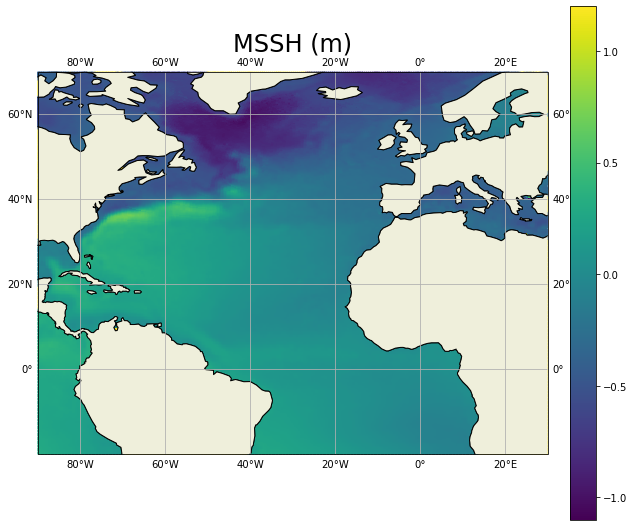

In [10]:
# let's plot MSSH

# define the projection 
data_crs = ccrs.PlateCarree()
projection=ccrs.PlateCarree(central_longitude=0)

# define the features we want to plot on the map 
f = plt.figure(figsize=(10, 10))
ax = plt.axes(projection=projection)
ax.set_extent([-90, 30, -20, 70],crs=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
ax.add_feature(cfeature.LAND, zorder=1, edgecolor='k')
ax.set_title("MSSH (m)",fontsize=24)

# plot MSSH
im = ax.pcolor(lon_grid, lat_grid, mssh5,vmin = -1.1, vmax= 1.2,shading='nearest')
plt.colorbar(im,fraction=0.046, pad=0.04)
plt.savefig('DIVE/FIGURES/Part4/mssh.png')

<div class="alert alert-block alert-success"

**Question 1 :** Can you identify the principal currents in that area?

Now let's overlay the altimeter tracks with data available on the 4th of november 2012.

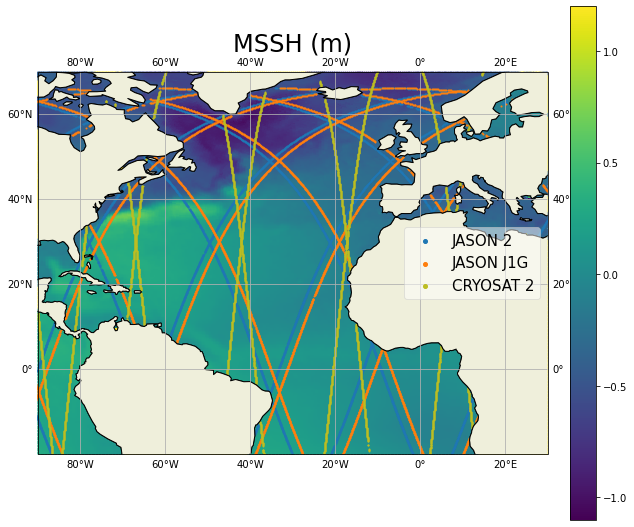

In [11]:
# overlay MSSH and altimeter tracks

# define the features we want to plot on the map 
f = plt.figure(figsize=(10, 10))
ax = plt.axes(projection=projection)
ax.set_extent([-90, 30, -20, 70],crs=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
ax.add_feature(cfeature.LAND, zorder=1, edgecolor='k')
ax.set_title("MSSH (m)",fontsize=24)

# plot data
im = ax.pcolor(lon_grid, lat_grid, mssh5,vmin = -1.1, vmax= 1.2,shading='nearest')
j2 = ax.scatter(lon_j2,lat_j2,c='tab:blue',s=1,label='JASON 2')
j1g = ax.scatter(lon_j1g,lat_j1g,c='tab:orange',s=1,label='JASON 1G')
c2 = ax.scatter(lon_c2,lat_c2,c='tab:olive',s=1,label='CRYOSAT 2')

ax.legend((j2,j1g,c2),('JASON 2', 'JASON J1G','CRYOSAT 2'),loc=0,fontsize=15,framealpha=0.5,markerscale=4) 
plt.colorbar(im,fraction=0.046, pad=0.04)
plt.savefig('DIVE/FIGURES/Part4/mssh+tracks.png')

Let's look at the analysed Sea Surface Height (SSH) with the 1/12° system on November 4th 2012 for the different OSE experiments (0 to 3 altimeters assimilated).

The assimilated tracks are superimposed on the MDT field.

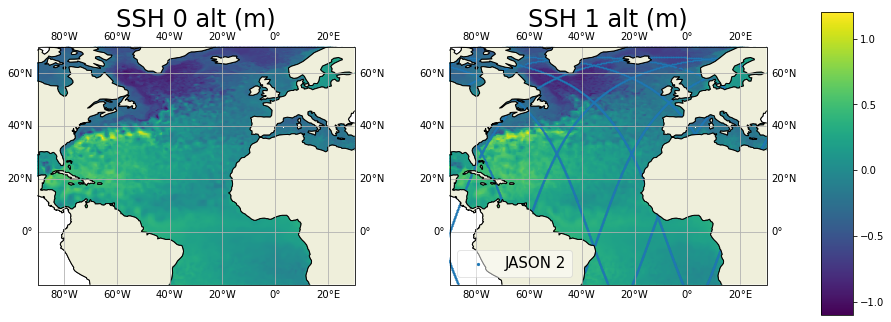

In [12]:
# define the subplots
f = plt.figure(figsize=(15, 12))
ax1 = f.add_subplot(121,projection=ccrs.PlateCarree())
ax2 = f.add_subplot(122,projection=ccrs.PlateCarree())

for ax in [ax1,ax2]:
    ax.set_extent([-90, 30, -20, 70],crs=ccrs.PlateCarree())
    ax.coastlines()
    ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
    ax.add_feature(cfeature.LAND, zorder=1, edgecolor='k')

# left plot 
im = ax1.pcolor(lon_grid, lat_grid, file1['sossheig'].data[0],vmin = -1.1, vmax= 1.2,shading='nearest')


# right plot
im = ax2.pcolor(lon_grid, lat_grid, file2['sossheig'].data[0],vmin = -1.1, vmax= 1.2,shading='nearest')
j2 = ax2.scatter(lon_j2,lat_j2,c='tab:blue',s=0.3,label='JASON 2')


# legend
f.subplots_adjust(right=0.8,wspace=0.3)
cbar_ax = f.add_axes([0.85, 0.33, 0.03, 0.35])
f.colorbar(im, cax=cbar_ax)
ax1.set_title("SSH 0 alt (m)",fontsize=24)
ax2.set_title("SSH 1 alt (m)",fontsize=24)
ax2.legend(handles = [j2],loc=0,fontsize=15,framealpha=0.5,markerscale=4) 

plt.savefig('DIVE/FIGURES/Part4/ssh_0_1_alt.png')

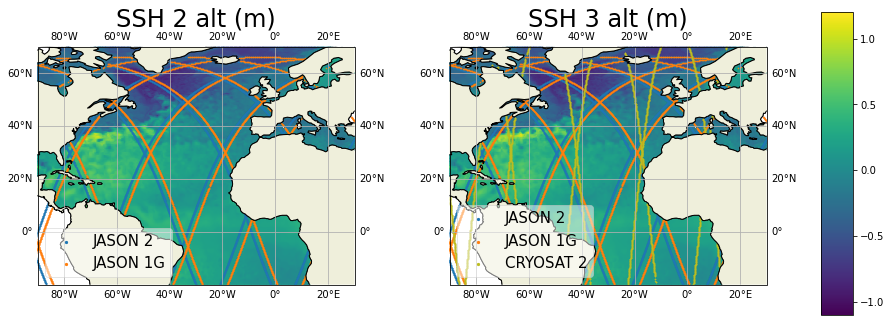

In [13]:
# define the subplots
f = plt.figure(figsize=(15, 12))
ax1 = f.add_subplot(121,projection=ccrs.PlateCarree())
ax2 = f.add_subplot(122,projection=ccrs.PlateCarree())

for ax in [ax1,ax2]:
    ax.set_extent([-90, 30, -20, 70],crs=ccrs.PlateCarree())
    ax.coastlines()
    ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
    ax.add_feature(cfeature.LAND, zorder=1, edgecolor='k')

# left plot 
im = ax1.pcolor(lon_grid, lat_grid, file3['sossheig'].data[0],vmin = -1.1, vmax= 1.2,shading='nearest')
j2 = ax1.scatter(lon_j2,lat_j2,c='tab:blue',s=0.3,label='JASON 2')
j1g = ax1.scatter(lon_j1g,lat_j1g,c='tab:orange',s=0.3,label='JASON 1G')


# right plot
im = ax2.pcolor(lon_grid, lat_grid, file4['sossheig'].data[0],vmin = -1.1, vmax= 1.2,shading='nearest')
j2 = ax2.scatter(lon_j2,lat_j2,c='tab:blue',s=0.3,label='JASON 2')
j1g = ax2.scatter(lon_j1g,lat_j1g,c='tab:orange',s=0.3,label='JASON 1G')
c2 = ax2.scatter(lon_c2,lat_c2,c='tab:olive',s=0.3,label='CRYOSAT 2')


# legend
f.subplots_adjust(right=0.8,wspace=0.3)
cbar_ax = f.add_axes([0.85, 0.33, 0.03, 0.35])
f.colorbar(im, cax=cbar_ax)
ax1.set_title("SSH 2 alt (m)",fontsize=24)
ax1.legend(handles = [j2,j1g],loc=0,fontsize=15,framealpha=0.5,markerscale=4) 
ax2.set_title("SSH 3 alt (m)",fontsize=24)
ax2.legend(handles = [j2,j1g,c2],loc=0,fontsize=15,framealpha=0.5,markerscale=4) 

plt.savefig('DIVE/FIGURES/Part4/ssh_2_3_alt.png')

It is not really easy to see the differences induced by SLA assimilation looking at the raw SSH fields.

We now compute the differences between the OSE experiments to see    
the differences in the SSH fields induced by the assimilation of each additional altimeter.

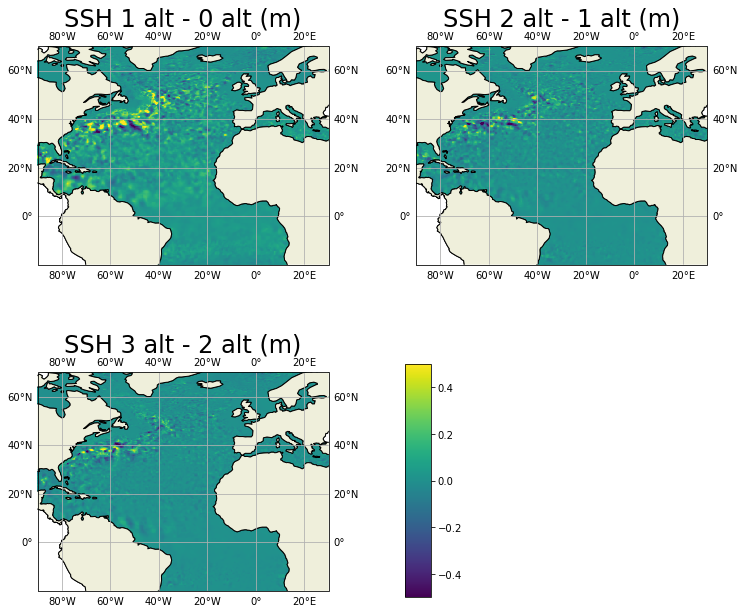

In [14]:
# define the subplots
f = plt.figure(figsize=(12, 12))
ax1 = f.add_subplot(221,projection=ccrs.PlateCarree())
ax2 = f.add_subplot(222,projection=ccrs.PlateCarree())
ax3 = f.add_subplot(223,projection=ccrs.PlateCarree())

for ax in [ax1,ax2,ax3]:
    ax.set_extent([-90, 30, -20, 70],crs=ccrs.PlateCarree())
    ax.coastlines()
    ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
    ax.add_feature(cfeature.LAND, zorder=1, edgecolor='k')

# upper left plot
im = ax1.pcolor(lon_grid, lat_grid, file2['sossheig'].data[0]- file1['sossheig'].data[0],vmin = -0.5, vmax= 0.5,shading='nearest')

# upper right plot
im = ax2.pcolor(lon_grid, lat_grid, file3['sossheig'].data[0]- file2['sossheig'].data[0],vmin = -0.5, vmax= 0.5,shading='nearest')

# lower left plot
im = ax3.pcolor(lon_grid, lat_grid, file4['sossheig'].data[0]- file3['sossheig'].data[0],vmin = -0.5, vmax= 0.5,shading='nearest')


# legend
ax1.set_title("SSH 1 alt - 0 alt (m)",fontsize=24)
ax2.set_title("SSH 2 alt - 1 alt (m)",fontsize=24)
ax3.set_title("SSH 3 alt - 2 alt (m)",fontsize=24)

cbar_ax = f.add_axes([0.55, 0.18, 0.03, 0.27])
f.subplots_adjust(hspace= 0.,wspace=0.3)
f.colorbar(im,cax=cbar_ax)

plt.savefig('DIVE/FIGURES/Part4/ssh_diff_alt.png')

As expected, when altimetry is assimilated, it generates differences in the estimated SSH.
The assimilation of data from the first altimeter (Jason2) has the greatest impact.
Additional assimilation of Jason 1G and then Cryosat 2 still has impatcs, but of lesser
magnitude. Differences are mostly found in energetic regions such as the Gulf Stream.

-------------
We now compare the different sea level anomalies [SLA =(SSH - MDT)]
estimated fields with the along track observations that were assimilated
in the given OSE experiments.

NB: You will see that 11 cm are substracted from the MSSH. As reference ellipsoid = geoid for the model, the MSSH is defined to a constant, and this constant is model dependant (you have to estimate it each time you change the settings), here it is 11 cm.

The symbol represents the different altimeter observation position and the inside colors
the observed values superimposed on the model values.

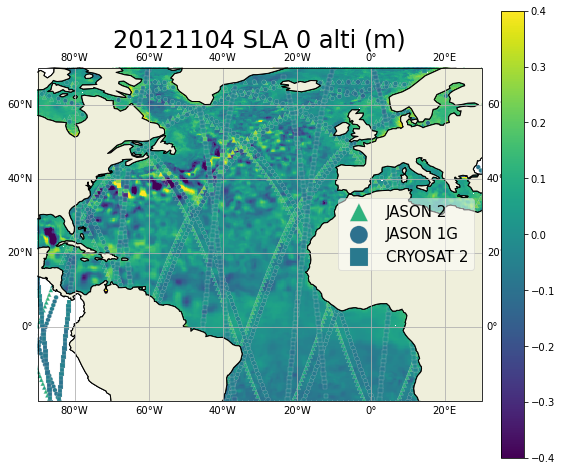

In [15]:
# define the features we want to plot on the map 
f = plt.figure(figsize=(10, 10))
ax = plt.axes(projection=projection)
ax.set_extent([-90, 30, -20, 70],crs=ccrs.PlateCarree())
ax.coastlines()
ax.coastlines()
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
ax.add_feature(cfeature.LAND, zorder=1, edgecolor='k')

# plot data
im = ax.pcolor(lon_grid, lat_grid, file1['sossheig'].data[0] - mssh5-0.11   ,vmin = -0.4, vmax= 0.4,shading='nearest')

# uncomment the following and run cell again to see the observation
j2 = ax.scatter(lon_j2[0:23457:10],lat_j2[0:23457:10],c=sla_j2[0:23457:10],marker='^',edgecolors='0.8',linewidth = 0.2, s=20,label='JASON 2')
j1g = ax.scatter(lon_j1g[0:25304:10],lat_j1g[0:25304:10],c=sla_j1g[0:25304:10],marker='o',edgecolors='0.8',linewidth = 0.2,s=20,label='JASON 1G')
c2 = ax.scatter(lon_c2[0:22332:10],lat_c2[0:22332:10],c=sla_c2[0:22332:10],s=20,marker = 's', edgecolors='0.8',linewidth = 0.2, label='CRYOSAT 2')
 
#legend
f.subplots_adjust(right=0.8,wspace=0.6)
plt.colorbar(im,fraction=0.046, pad=0.04)
ax.set_title("20121104 SLA 0 alti (m)",fontsize=24)
ax.legend(handles = [j2,j1g,c2],loc=0,fontsize=15,framealpha=0.5,markerscale=4) 

plt.savefig('DIVE/FIGURES/Part4/sla0+obs.png')

<div class="alert alert-block alert-success"

**Question 2 :** Now change to 1 altimeter, 2 and 3 altimeters assimilated.

We now draw scatter plot of model values at the observation point
vs altimetry observed values to verify that changes seen
in the SSH field corresponds to a reduction of model - observations misfits,
thanks to the assimilation process.

First we subsample the observations (1 point over 10).

In [16]:
# subsample observations
sla_j2_sub = sla_j2[0:23457:10]
lat_j2_sub = lat_j2[0:23457:10]
lon_j2_sub = lon_j2[0:23457:10]

sla_j1g_sub = sla_j1g[0:25304:10]
lon_j1g_sub = lon_j1g[0:25304:10]
lat_j1g_sub = lat_j1g[0:25304:10]

sla_c2_sub = sla_c2[0:22332:10]
lon_c2_sub = lon_c2[0:22332:10]
lat_c2_sub = lat_c2[0:22332:10]

Now we extract the model values at the time and location of the observations.

In [17]:
# interpolate model value at the time and location of the observations
# 2D-interpolation with griddata( (lat_model,lon_model),  model_values, (lat_obs,lon_obs)) 

mssh_j2 = griddata((lat_grid.flatten(),lon_grid.flatten()),mssh5.flatten(),(lat_j2_sub,lon_j2_sub))
zero_j2 = griddata((lat_grid.flatten(),lon_grid.flatten()),file1['sossheig'].data[0].flatten(),(lat_j2_sub,lon_j2_sub))
one_j2 = griddata((lat_grid.flatten(),lon_grid.flatten()),file2['sossheig'].data[0].flatten(),(lat_j2_sub,lon_j2_sub))
two_j2 = griddata((lat_grid.flatten(),lon_grid.flatten()),file3['sossheig'].data[0].flatten(),(lat_j2_sub,lon_j2_sub))
three_j2 = griddata((lat_grid.flatten(),lon_grid.flatten()),file4['sossheig'].data[0].flatten(),(lat_j2_sub,lon_j2_sub))

mssh_j1g = griddata((lat_grid.flatten(),lon_grid.flatten()),mssh5.flatten(),(lat_j1g_sub,lon_j1g_sub))
zero_j1g = griddata((lat_grid.flatten(),lon_grid.flatten()),file1['sossheig'].data[0].flatten(),(lat_j1g_sub,lon_j1g_sub))
one_j1g = griddata((lat_grid.flatten(),lon_grid.flatten()),file2['sossheig'].data[0].flatten(),(lat_j1g_sub,lon_j1g_sub))
two_j1g = griddata((lat_grid.flatten(),lon_grid.flatten()),file3['sossheig'].data[0].flatten(),(lat_j1g_sub,lon_j1g_sub))
three_j1g = griddata((lat_grid.flatten(),lon_grid.flatten()),file4['sossheig'].data[0].flatten(),(lat_j1g_sub,lon_j1g_sub))

mssh_c2 = griddata((lat_grid.flatten(),lon_grid.flatten()),mssh5.flatten(),(lat_c2_sub,lon_c2_sub))
zero_c2 = griddata((lat_grid.flatten(),lon_grid.flatten()),file1['sossheig'].data[0].flatten(),(lat_c2_sub,lon_c2_sub))
one_c2 = griddata((lat_grid.flatten(),lon_grid.flatten()),file2['sossheig'].data[0].flatten(),(lat_c2_sub,lon_c2_sub))
two_c2 = griddata((lat_grid.flatten(),lon_grid.flatten()),file3['sossheig'].data[0].flatten(),(lat_c2_sub,lon_c2_sub))
three_c2 = griddata((lat_grid.flatten(),lon_grid.flatten()),file4['sossheig'].data[0].flatten(),(lat_c2_sub,lon_c2_sub))


Finally we compute RMS differences between altimetry observations and
modeled sea level anomalies.

In [18]:
diff_zero_j2  = sla_j2_sub - (zero_j2 -mssh_j2 -0.11)
diff_one_j2   = sla_j2_sub - (one_j2  -mssh_j2 -0.11)
diff_two_j2   = sla_j2_sub - (two_j2  -mssh_j2 -0.11)
diff_three_j2 = sla_j2_sub - (three_j2-mssh_j2 -0.11)

diff_zero_j1g  = sla_j1g_sub - (zero_j1g -mssh_j1g -0.11)
diff_one_j1g   = sla_j1g_sub - (one_j1g  -mssh_j1g-0.11)
diff_two_j1g   = sla_j1g_sub - (two_j1g  -mssh_j1g-0.11)
diff_three_j1g = sla_j1g_sub - (three_j1g-mssh_j1g-0.11)

diff_zero_c2  = sla_c2_sub - (zero_c2  -mssh_c2-0.11)
diff_one_c2   = sla_c2_sub - (one_c2   -mssh_c2-0.11)
diff_two_c2   = sla_c2_sub - (two_c2   -mssh_c2-0.11)
diff_three_c2 = sla_c2_sub - (three_c2 -mssh_c2-0.11)


RMSD_j2_zero  = np.nanvar(diff_zero_j2)**0.5  
RMSD_j2_one    = np.nanvar(diff_one_j2)**0.5
RMSD_j2_two   = np.nanvar(diff_two_j2)**0.5   
RMSD_j2_three  = np.nanvar(diff_three_j2)**0.5
RMSD_j1g_zero = np.nanvar(diff_zero_j1g)**0.5 
RMSD_j1g_one   = np.nanvar(diff_one_j1g)**0.5
RMSD_j1g_two  = np.nanvar(diff_two_j1g)**0.5 
RMSD_j1g_three = np.nanvar(diff_three_j1g)**0.5
RMSD_c2_zero  = np.nanvar(diff_zero_c2)**0.5 
RMSD_c2_one    = np.nanvar(diff_one_c2)**0.5
RMSD_c2_two   = np.nanvar(diff_two_c2)**0.5   
RMSD_c2_three  = np.nanvar(diff_three_c2)**0.5

We now draw the scatterplots for zero and one assimilated altimeter.

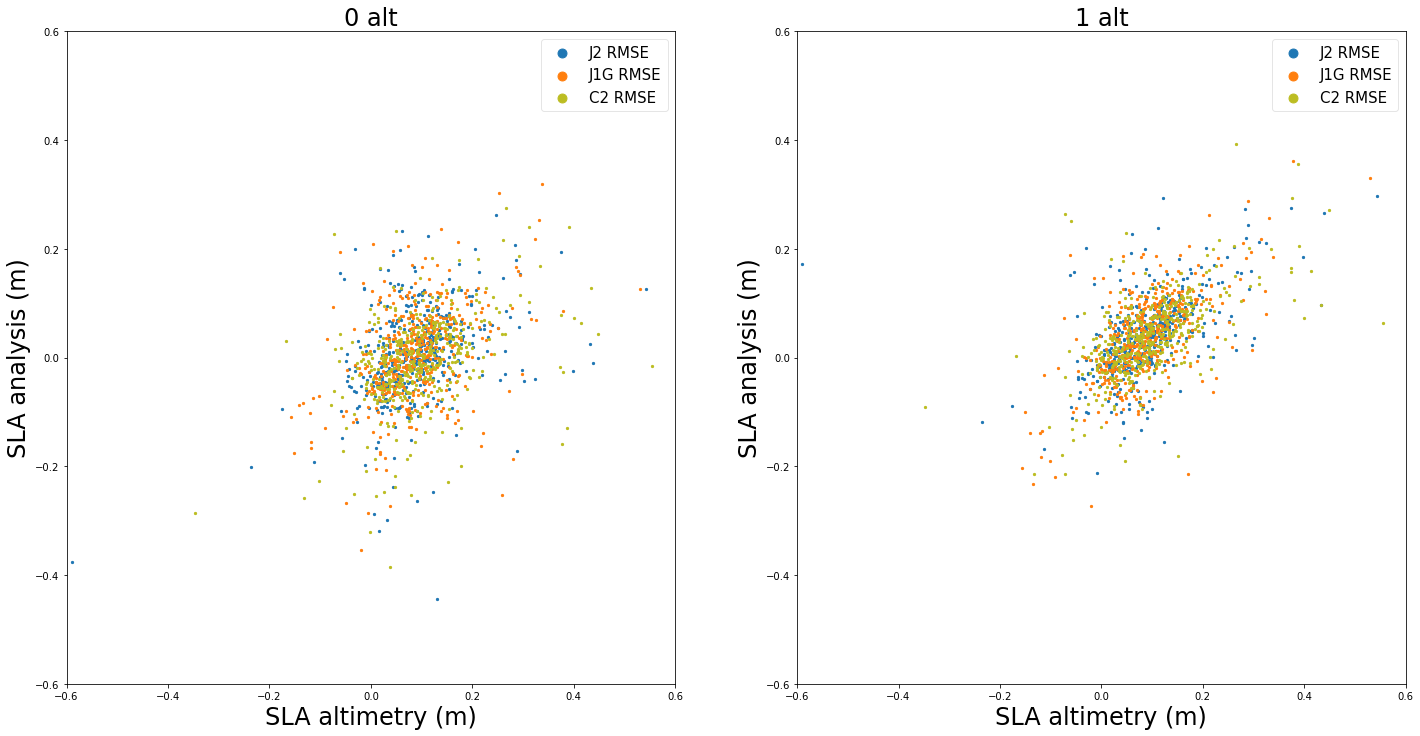

In [19]:
# define subplots 
f = plt.figure(figsize=(24, 12))
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)

# left plot
ax1.set(xlim=(-0.6,0.6), ylim=(-0.6,0.6))
ax1.set_xlabel('SLA altimetry (m)',fontsize=24)
ax1.set_ylabel('SLA analysis (m)',fontsize=24)
ax1.set_title("0 alt",fontsize=24)

j2 = ax1.scatter(sla_j2[0:23457:10],zero_j2-mssh_j2-0.11,c='tab:blue',s=5,label='JASON 2')
j1g = ax1.scatter(sla_j1g[0:25304:10],zero_j1g-mssh_j1g-0.11,c='tab:orange',s=5,label='JASON 1G')
c2 = ax1.scatter(sla_c2[0:22332:10],zero_c2-mssh_c2-0.11,c='tab:olive',s=5,label='CRYOSAT 2')

ax1.legend((j2,j1g,c2),('J2 RMSE', 'J1G RMSE','C2 RMSE'),loc=0,fontsize=15,framealpha=0.5,markerscale=4) 

# right plot
ax2.set(xlim=(-0.6,0.6), ylim=(-0.6,0.6))
ax2.set_xlabel('SLA altimetry (m)',fontsize=24)
ax2.set_ylabel('SLA analysis (m)',fontsize=24)
ax2.set_title("1 alt",fontsize=24)

j2 = ax2.scatter(sla_j2[0:23457:10],one_j2-mssh_j2-0.11,c='tab:blue',s=5,label='JASON 2')
j1g = ax2.scatter(sla_j1g[0:25304:10],one_j1g-mssh_j1g-0.11,c='tab:orange',s=5,label='JASON 1G')
c2 = ax2.scatter(sla_c2[0:22332:10],one_c2-mssh_c2-0.11,c='tab:olive',s=5,label='CRYOSAT 2')

ax2.legend((j2,j1g,c2),('J2 RMSE', 'J1G RMSE','C2 RMSE'),loc=0,fontsize=15,framealpha=0.5,markerscale=4) 
plt.savefig('DIVE/FIGURES/Part4/slaanlysis_vs_altimetry_0_1.png')

<div class="alert alert-block alert-success"

**Question 3 :** Create a new cell to do the same for 2 and 3  assimilated altimeters and compare the scatterplots, what can you see? 

The dispersion of the cloud of differences between altimetry observations and analyzed SLA is being reduced as data from more and more altimeters are assimilated. This illustrates the success of the assimilation procedure.

To quantify the better fit of the analyzed fields to satellite altimetry observations, RMS of differences between sea level anomalies from altimetry and from the model are computed and listed on the plots.

Such statistics are used to check the success of the assimilation procedure and give quantitative measure of the improvements.

We see that RMSD are getting smaller when data from more altimeters are being assimilated.

Now let's have a look at one section across the Gulf Stream in SSH.

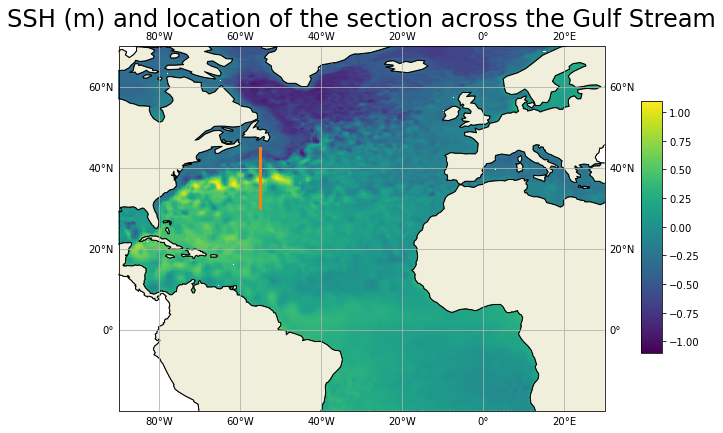

In [20]:
# define the section
xpts =-55.+0.*np.array(range(1,150))
ypts = 30+0.1*np.array(range(1,150))

# check how the points overlay on the original grid
# define the features we want to plot on the map 
f = plt.figure(figsize=(10, 10))
ax = plt.axes(projection=projection)
ax.set_extent([-90, 30, -20, 70],crs=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
ax.add_feature(cfeature.LAND, zorder=1, edgecolor='k')
ax.set_title("SSH (m) and location of the section across the Gulf Stream",fontsize=24)

# plot data
im = ax.pcolor(lon_grid, lat_grid, file1['sossheig'].data[0] ,vmin = -1.1, vmax= 1.1,shading='nearest')
ax.plot(xpts,ypts,c='tab:orange',linewidth=3,transform=data_crs)

# legend
f.subplots_adjust(right=0.8,wspace=0.3)
cbar_ax = f.add_axes([0.85, 0.33, 0.03, 0.35])
f.colorbar(im, cax=cbar_ax)

plt.savefig('DIVE/FIGURES/Part4/ssh+section.png')

Now we subsample the model experiments along this section.

In [21]:
# interpolate model value at the time and location of the observations
# 2D-interpolation with griddata( (lat_model,lon_model),  model_values, (lat_obs,lon_obs))

zero = griddata((lat_grid.flatten(),lon_grid.flatten()),file1['sossheig'].data[0].flatten(),(ypts,xpts))
one = griddata((lat_grid.flatten(),lon_grid.flatten()),file2['sossheig'].data[0].flatten(),(ypts,xpts))
two = griddata((lat_grid.flatten(),lon_grid.flatten()),file3['sossheig'].data[0].flatten(),(ypts,xpts))
three = griddata((lat_grid.flatten(),lon_grid.flatten()),file4['sossheig'].data[0].flatten(),(ypts,xpts))

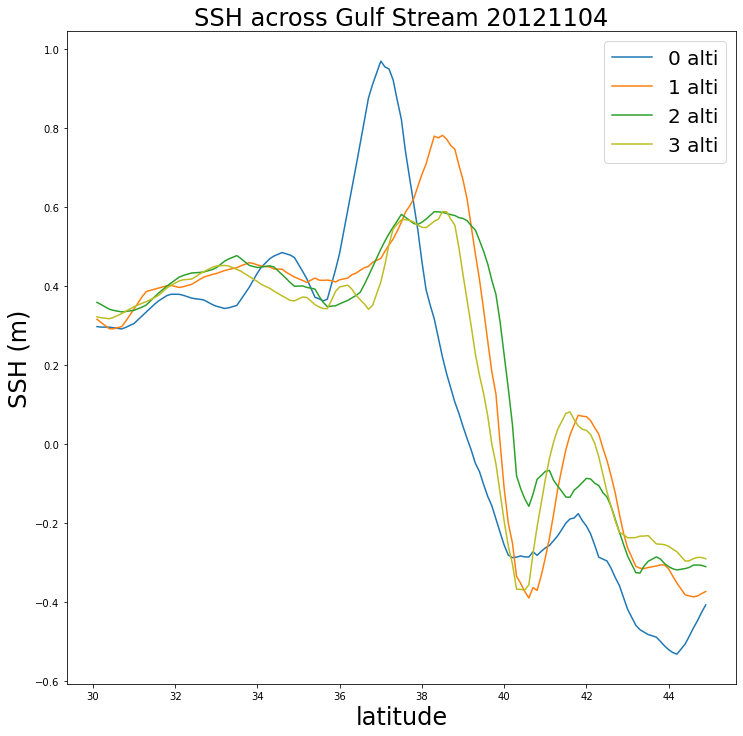

In [22]:
f = plt.figure(figsize=(12, 12))
ax = plt.axes()

plotzero, = ax.plot(ypts,zero,c='tab:blue',label = '0 alti')
plotone, = ax.plot(ypts,one,c='tab:orange',label = '1 alti')
plottwo, = ax.plot(ypts,two,c='tab:green',label = '2 alti')
plotthree, = ax.plot(ypts,three,c='tab:olive',label = '3 alti')

ax.set_xlabel('latitude',fontsize=24)
ax.set_ylabel('SSH (m)',fontsize=24)
ax.set_title("SSH across Gulf Stream 20121104",fontsize=24)
ax.legend(handles = [plotzero,plotone,plottwo,plotthree],fontsize=20) 
plt.savefig('DIVE/FIGURES/Part4/ssh_across_section.png')

<div class="alert alert-block alert-success"

**Question 4 :**  Now overlay the mean SSH on this plot (look out, there's a catch!).

Altimetry assimilation helps the model producing a more realistic position of the Gulf Stream Front thanks to the SSH data assimilation

When 2 or 3 altimeters are available, mesoscale features can be better constrained.


## 2. Temperature

After looking at the SSH estimation accross the Gulf Stream, we will now look at the vertical temperature estimation and the temperature changes produced by the assimilation of altimeter SLA data.

In [23]:
# define the paths of the netcdf files to use

path_file6 = 'DIVE/OSE/DATA/Data6/RUN_0ALTI/PSY2V4R4_1dAV_20121104_20121105_gridT_R20121107_1outof4.nc'
path_file7 = 'DIVE/OSE/DATA/Data6/RUN_1ALTI/PSY2V4R4_1dAV_20121104_20121105_gridT_R20121107_1outof4.nc'
path_file8 = 'DIVE/OSE/DATA/Data6/RUN_2ALTI/PSY2V4R4_1dAV_20121104_20121105_gridT_R20121107_1outof4.nc'
path_file9 = 'DIVE/OSE/DATA/Data6/RUN_3ALTI/PSY2V4R4_1dAV_20121104_20121105_gridT_R20121107_1outof4.nc'
path_file10 = 'DIVE/OSE/DATA/Data6/ARMOR3D_20121107.nc'

# open the netcdf files
file6 = xr.open_dataset(path_file6)
file7 = xr.open_dataset(path_file7)
file8 = xr.open_dataset(path_file8)
file9 = xr.open_dataset(path_file9)
file10 = xr.open_dataset(path_file10)

Let's subsample the model experiments' temperatures onto our Gulf Stream section.

In [24]:
# define the section
xpts =-55.+0.*np.array(range(1,50))
ypts = 30+0.3*np.array(range(1,50))

# set the depth of the model and observations
depth_armor = file10['depth'].data
depth_model = file6['deptht'].data

# set the variables : lon ( -180:180 ! ), lat, temperature alog the section ()
armor = file10['temperature'].data[:,552:609,915]   # values along the section : all depths, lats[30:45], lon[-55]
lon_armor = file10['longitude'].data
for i in range(len(lon_armor)):
    if lon_armor[i]>180:
        lon_armor[i]=lon_armor[i]-360


lat_armor = file10['latitude'].data

# initialize the arrays of the vertical profiles
temp_zero =[]
temp_one =[]
temp_two =[]
temp_three =[]

# interpolate the model data on the section for each depth layer 
for i in range(len(depth_model)):
    temp_zero_tmp = griddata((lat_grid.flatten(),lon_grid.flatten()),file6['votemper'].data[0,i].flatten(),(ypts,xpts))
    temp_one_tmp = griddata((lat_grid.flatten(),lon_grid.flatten()),file7['votemper'].data[0,i].flatten(),(ypts,xpts))
    temp_two_tmp = griddata((lat_grid.flatten(),lon_grid.flatten()),file8['votemper'].data[0,i].flatten(),(ypts,xpts))
    temp_three_tmp = griddata((lat_grid.flatten(),lon_grid.flatten()),file9['votemper'].data[0,i].flatten(),(ypts,xpts))
    
    temp_zero.append(temp_zero_tmp)
    temp_one.append(temp_one_tmp)
    temp_two.append(temp_two_tmp)
    temp_three.append(temp_three_tmp)
    

# transform data into array to plot
temp_zero = np.array(temp_zero)
temp_one = np.array(temp_one)
temp_two = np.array(temp_two)
temp_three = np.array(temp_three)

/opt/anaconda3/envs/unesco/lib/python3.7/site-packages/ipykernel/__main__.py:13: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


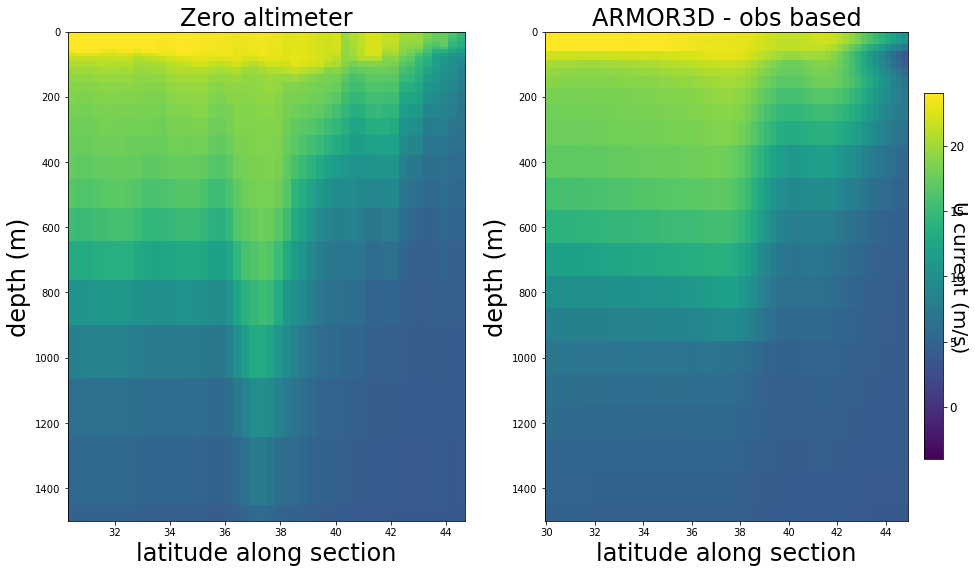

In [25]:
# define subplots
f = plt.figure(figsize=(18, 9))
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)

# left plot
ax1.set_xlabel('latitude along section',fontsize=24)
ax1.set_ylabel('depth (m)',fontsize=24)
ax1.set_title("Zero altimeter",fontsize=24)
ax1.set(ylim=(0,1500))
ax1.invert_yaxis()

im = ax1.pcolor(ypts,depth_model,temp_zero,vmin = -4, vmax= 24)
plt.gca().invert_yaxis()

# right plot
ax2.set(ylim=(0,1500))
ax2.set_xlabel('latitude along section',fontsize=24)
ax2.set_ylabel('depth (m)',fontsize=24)
ax2.set_title("ARMOR3D - obs based",fontsize=24)
ax2.invert_yaxis()

im = ax2.pcolor(lat_armor[552:609],depth_armor,armor,vmin = -4, vmax= 24,shading='nearest')


# legend
f.subplots_adjust(right=0.8)
cbar = f.colorbar(im,fraction=0.046, pad=0.04)
cbar.set_label('U current (m/s)', rotation=270,fontsize=20)
cbar.ax.tick_params(labelsize=12)
plt.savefig('DIVE/FIGURES/Part4/alt0_vs_armor.png')


<div class="alert alert-block alert-success"

**Question 5 :**  Change the plot to look at all experiments compared to ARMOR3D. 


We can see that important changes are seen even at depth on temperature, especially on the front.
Even if the ARMOR3D field is smoother, we can see a good agreement between the 2 estimations.

Let's look at the depth of the isotherm 12°C.

In [26]:
# initialize isolines
isoT12_zero = []
isoT12_one = []
isoT12_two = []
isoT12_three = []

# get the depth where T = 12°C
for j in range(len(ypts)):
    idx = np.nanargmin(np.abs(temp_zero[:,j] - 12))
    isoT12_zero.append(depth_model[idx])
    
    idx = np.nanargmin(np.abs(temp_one[:,j] - 12))
    isoT12_one.append(depth_model[idx])
    
    idx = np.nanargmin(np.abs(temp_two[:,j] - 12))
    isoT12_two.append(depth_model[idx])
    
    idx = np.nanargmin(np.abs(temp_three[:,j] - 12))
    isoT12_three.append(depth_model[idx])

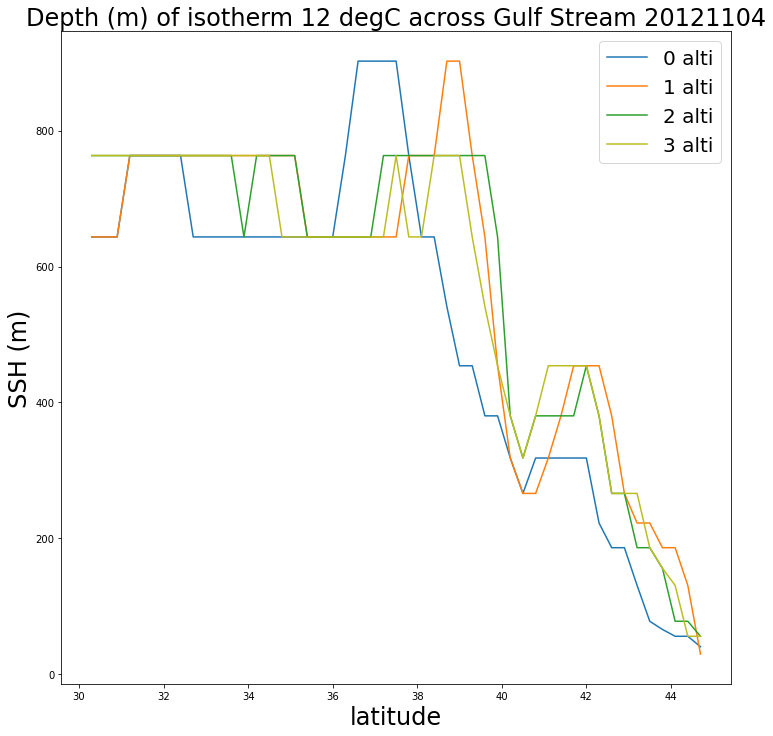

In [27]:
# define the plot
f = plt.figure(figsize=(12, 12))
ax = plt.axes()
ax.set_xlabel('latitude',fontsize=24)
ax.set_ylabel('SSH (m)',fontsize=24)
ax.set_title("Depth (m) of isotherm 12 degC across Gulf Stream 20121104",fontsize=24)

# plot
plotzero, = ax.plot(ypts,isoT12_zero,c='tab:blue',label = '0 alti')
plotone, = ax.plot(ypts,isoT12_one,c='tab:orange',label = '1 alti')
plottwo, = ax.plot(ypts,isoT12_two,c='tab:green',label = '2 alti')
plotthree, = ax.plot(ypts,isoT12_three,c='tab:olive',label = '3 alti')

# legend
ax.legend(handles = [plotzero,plotone,plottwo,plotthree],fontsize=20)   
plt.savefig('DIVE/FIGURES/Part4/depth_iso_12.png')


<div class="alert alert-block alert-success"

**Question 6 :** Overlay on this plot the isotherm 12°C from the two alti and three alti experiments. 

## 3. Currents 
Do we see some changes inside the Gulf Stream current?  
Let's subsample the velocities along our Gulf Stream section.

In [28]:
# define the paths of the netcdf files to use
path_file11 = 'DIVE/OSE/DATA/Data6/RUN_0ALTI/PSY2V4R4_1dAV_20121104_20121105_gridU_R20121107_1outof4.nc'
path_file12 = 'DIVE/OSE/DATA/Data6/RUN_0ALTI/PSY2V4R4_1dAV_20121104_20121105_gridV_R20121107_1outof4.nc'
path_file13 = 'DIVE/OSE/DATA/Data6/RUN_3ALTI/PSY2V4R4_1dAV_20121104_20121105_gridU_R20121107_1outof4.nc'
path_file14 = 'DIVE/OSE/DATA/Data6/RUN_3ALTI/PSY2V4R4_1dAV_20121104_20121105_gridV_R20121107_1outof4.nc'

# open the netcdf file
file11 = xr.open_dataset(path_file11)
file12 = xr.open_dataset(path_file12)
file13 = xr.open_dataset(path_file13)
file14 = xr.open_dataset(path_file14)

# set depth model variable
depth_model = file11['deptht'].data

#initialize u velocities 
u_zero = []
u_three = []

# interpolate current values along the section for each depth layer and build vertical section
# 2D-interpolation with griddata( (lat_model,lon_model),  model_values, (lat_obs,lon_obs)) 
for i in range(len(depth_model)):
    u_zero_tmp = griddata((lat_grid.flatten(),lon_grid.flatten()),file11['vozocrtx'].data[0,i].flatten(),(ypts,xpts))
    u_three_tmp = griddata((lat_grid.flatten(),lon_grid.flatten()),file13['vozocrtx'].data[0,i].flatten(),(ypts,xpts))
    
    u_zero.append(u_zero_tmp)
    u_three.append(u_three_tmp)
    


/opt/anaconda3/envs/unesco/lib/python3.7/site-packages/ipykernel/__main__.py:31: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().


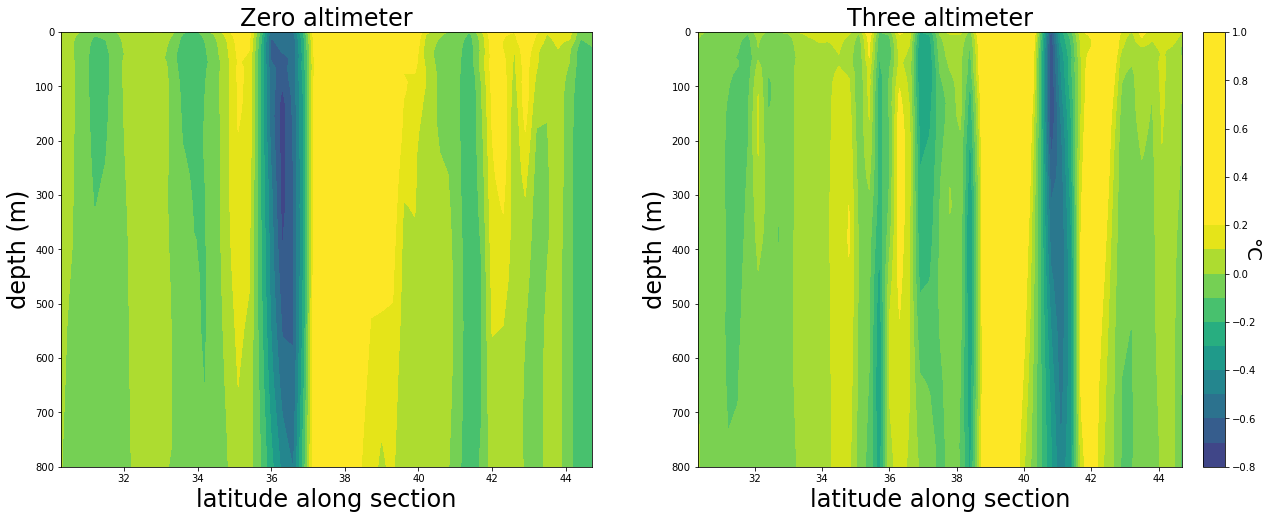

In [29]:
# define subplots
f = plt.figure(figsize=(24, 8))
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)

#left plot
ax1.set(ylim=(0,800))
ax1.set_xlabel('latitude along section',fontsize=24)
ax1.set_ylabel('depth (m)',fontsize=24)
ax1.set_title("Zero altimeter",fontsize=24)
ax1.invert_yaxis()

#im = ax1.pcolor(ypts,depth_model,u_zero,vmin = -1, vmax= 0.1)
im = ax1.contourf(ypts,depth_model,u_zero,20, vmin = -1, vmax= 0.2)

# right plot
ax2.set(ylim=(0,800))
ax2.set_xlabel('latitude along section',fontsize=24)
ax2.set_ylabel('depth (m)',fontsize=24)
ax2.set_title("Three altimeter",fontsize=24)
ax2.invert_yaxis()

#im = ax2.pcolor(ypts,depth_model,u_three,vmin = -1, vmax= 0.1)
im2 = ax2.contourf(ypts,depth_model,u_three,20, vmin = -1, vmax= 0.2)


# legend
f.subplots_adjust(right=0.8)
#cbar_ax = f.add_axes([0.85, 0.33, 0.03, 0.35])
#f.colorbar(im, cax=cbar_ax)
cbar = f.colorbar(im,fraction=0.046, pad=0.04)
cbar.set_label('°C', rotation=270,fontsize=20)

plt.savefig('DIVE/FIGURES/Part4/vertical_profile_temp_0_3.png')


We can see that the location of the strongest current veins changes when data from 3 altimetry satellite are assimilated.

Now let's look at the surface currents.
They are superimposed on the SLA and SST estimation for the simulation with 0 and 3 altimeters.

/opt/anaconda3/envs/unesco/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1887: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = matplotlib.axes.Axes.pcolor(self, *args, **kwargs)
/opt/anaconda3/envs/unesco/lib/python3.7/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naciscdn.org/naturalearth/10m/physical/ne_10m_coastline.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)
/opt/anaconda3/envs/unesco/lib/python3.7/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naciscdn.org/naturalearth/10m/physical/ne_10m_land.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)


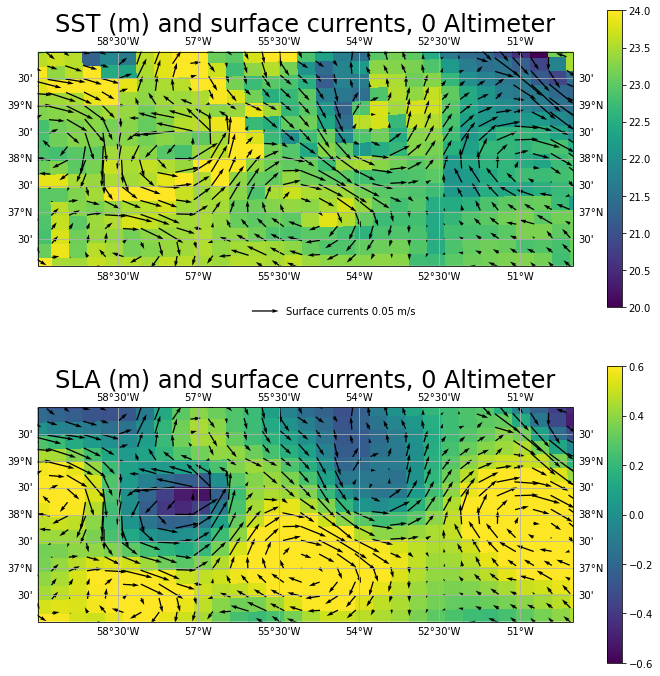

In [30]:
# define subplots
f = plt.figure(figsize=(12, 12))
ax1 = f.add_subplot(211,projection=ccrs.PlateCarree())
ax2 = f.add_subplot(212,projection=ccrs.PlateCarree())


for ax in [ax1,ax2]:
    ax.set_extent([-60, -50, 36, 40],crs=ccrs.PlateCarree())
    ax.coastlines()
    ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
    ax.add_feature(cfeature.LAND, zorder=1, edgecolor='k')
    
# left plot   
ax1.set_title("SST (m) and surface currents, 0 Altimeter",fontsize=24)
im1 = ax1.pcolor(lon_grid, lat_grid, file6['votemper'].data[0,0],vmin = 20, vmax= 24)
vect = ax1.quiver(lon_grid,lat_grid,file11['vozocrtx'].data[0,0],file12['vomecrty'].data[0,0],transform=data_crs,scale=20)

ax1.quiverkey(vect,X=2,Y=2,U=10,label='Surface currents (m/s)',labelpos='E')
plt.colorbar(im1,ax=ax1)

# right plot
ax2.set_title("SLA (m) and surface currents, 0 Altimeter",fontsize=24)
im2 = ax2.pcolor(lon_grid, lat_grid, file1['sossheig'].data[0],vmin = -0.6, vmax= 0.6)
vect = ax2.quiver(lon_grid,lat_grid,file11['vozocrtx'].data[0,0],file12['vomecrty'].data[0,0],transform=data_crs,scale=20)

ax2.quiverkey(vect,X=0.45,Y=1.45,U=1,label='Surface currents 0.05 m/s',labelpos='E')
f.colorbar(im2,ax=ax2)
plt.savefig('DIVE/FIGURES/Part4/sst_sla_current_0.png')


<div class="alert alert-block alert-success"

**Question 7 :** In a new cell, do the same plots when 3 altimeters are assimilated. 

The surface circulation and water properties highly differs between the two simulations.

You can now look at the impact of the SSH assimilation onto other variables such as SST, MLD...  Those variables are stored in the different data files that are found in  DIVE/OSE/DATA/Data6/ in files which name include grid2D and gridT.